In [1]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

<Axes: >

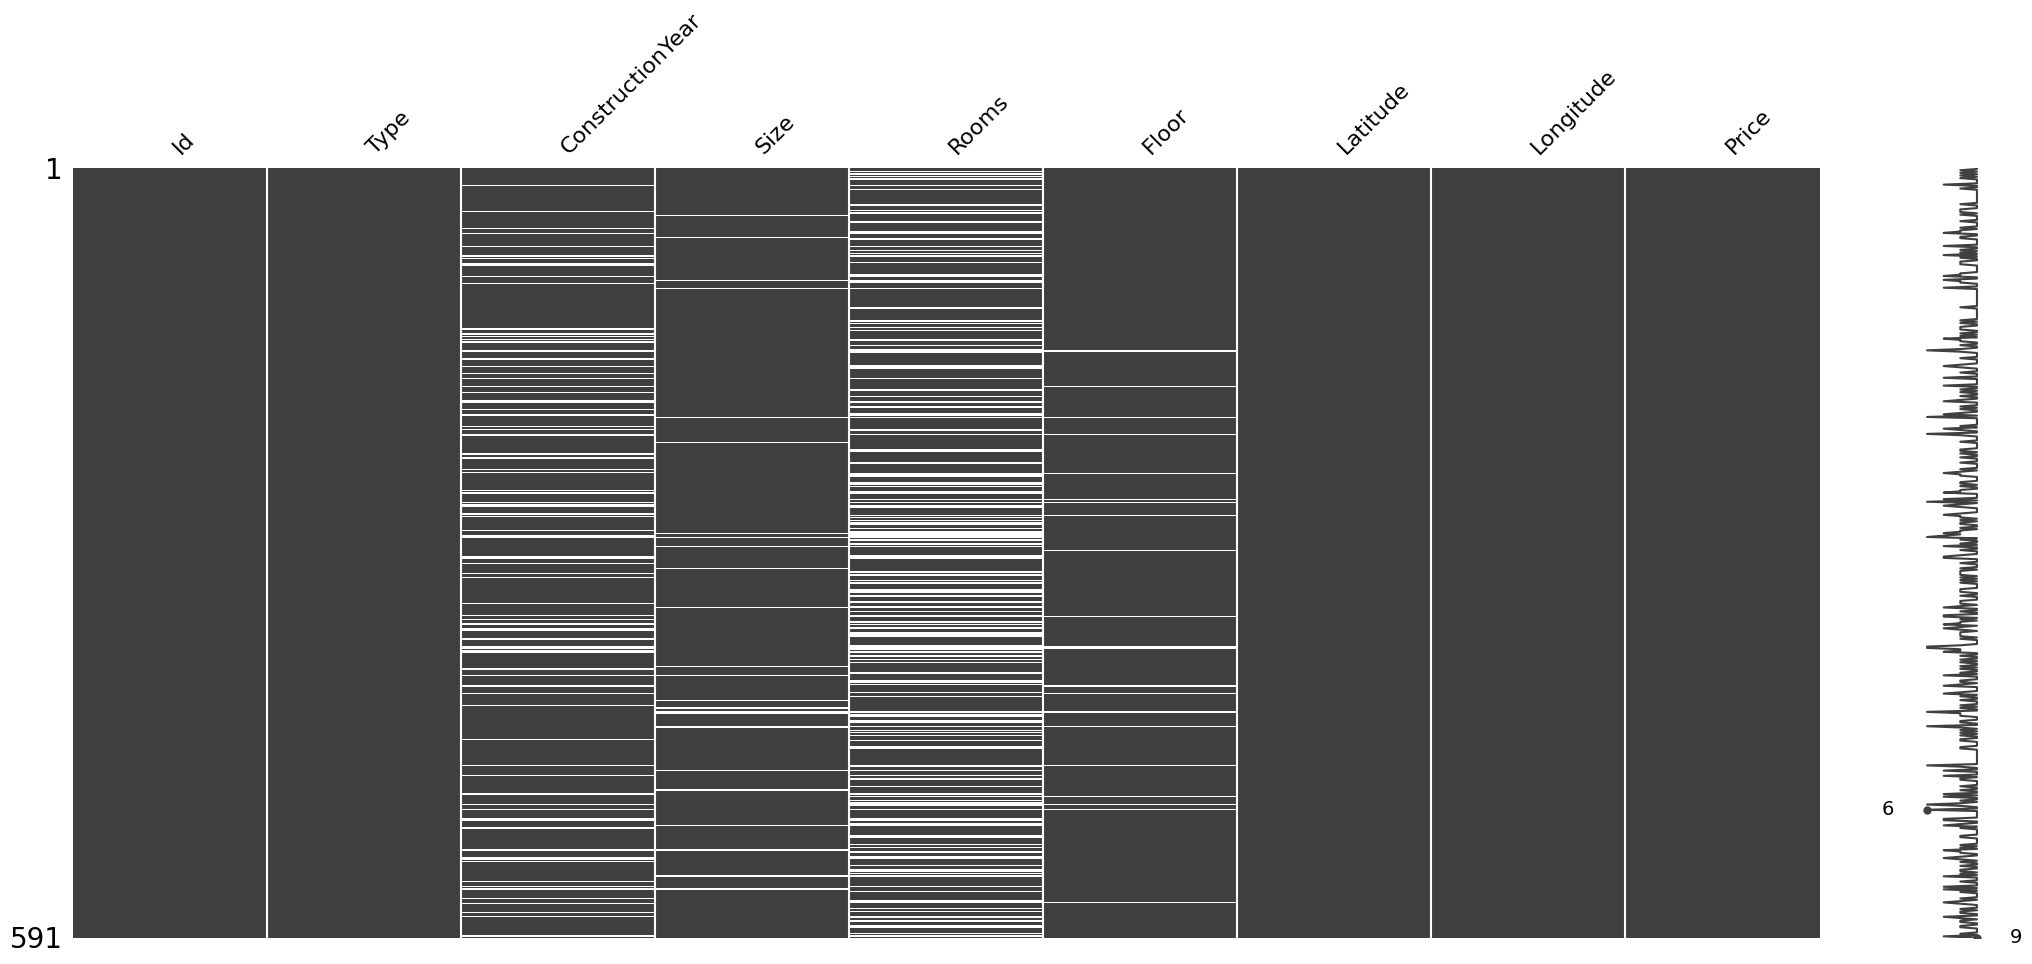

In [3]:
df_train = pd.read_csv("train.csv")


In [4]:
# Visualize and count missing values

msno.matrix(df_train)

for key, value in df_train.isnull().sum().items():
  print(f'Null percentage  { value / len(df_train) * 100} % for {key}')

Null percentage  0.0 % for Id
Null percentage  0.0 % for Type
Null percentage  14.890016920473773 % for ConstructionYear
Null percentage  4.230118443316413 % for Size
Null percentage  29.949238578680205 % for Rooms
Null percentage  3.5532994923857872 % for Floor
Null percentage  0.0 % for Latitude
Null percentage  0.0 % for Longitude
Null percentage  0.0 % for Price


<Axes: ylabel='Frequency'>

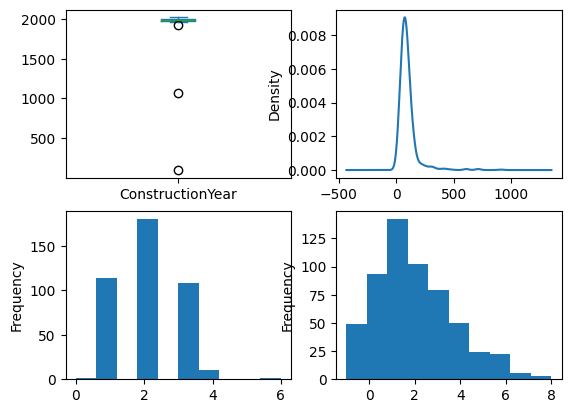

In [5]:
# Plot distribution of variables
fig, axes = plt.subplots(nrows=2, ncols=2)

df_train['ConstructionYear'].plot(ax=axes[0,0], kind='box')
df_train['Size'].plot(ax=axes[0,1],kind='kde')
df_train['Rooms'].plot(ax=axes[1,0], kind='hist')
df_train['Floor'].plot(ax=axes[1,1], kind='hist')

In [ ]:
# Define indexes to drop based on the z-score & the observations from the plots

# Calculate Z-score
numeric_cols = df_train.select_dtypes(include=[np.number]).columns
z = stats.zscore(df_train[numeric_cols], nan_policy='omit')

drop_indexes = []

drop_indexes = list(df_train[(np.abs(z['ConstructionYear']) > 0.6)].index)
# drop_indexes += list(df_train[df_train['Rooms'] == 6].index)
drop_indexes += list(df_train[df_train['Floor'] == 7].index)
drop_indexes += list(df_train[df_train['Floor'] == 8].index)


df_train.drop(drop_indexes, inplace=True)
df_train.drop(['Rooms'], axis=1, inplace=True)

df_train = df_train.reset_index(drop=False)
df_train.drop(['index'], axis=1, inplace=True)

<Axes: ylabel='Frequency'>

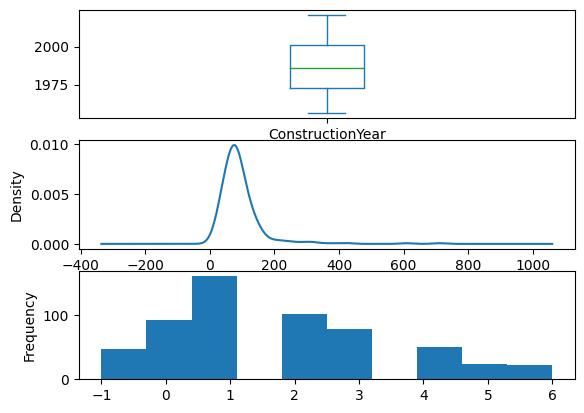

In [37]:
# Plot distribution of variables
fig, axes = plt.subplots(nrows=3, ncols=1)

df_train['ConstructionYear'].plot(ax=axes[0], kind='box')
df_train['Size'].plot(ax=axes[1],kind='kde')
df_train['Floor'].plot(ax=axes[2], kind='hist')

In [9]:
# Handle missing values

df_train["ConstructionYear"] = df_train["ConstructionYear"].fillna(df_train["ConstructionYear"].mean())
df_train["Size"] = df_train["Size"].fillna(df_train["Size"].median())
df_train["Floor"] = df_train["Floor"].fillna(df_train["Floor"].mode()[0])

df_train

Id        Type  ConstructionYear    Size  Floor   Latitude  Longitude  \
0    310  Διαμέρισμα       1960.000000   70.00    6.0  40.635462  22.950378   
1    841  Διαμέρισμα       1980.000000  103.50    4.0  40.608820  22.984239   
2    172     Γραφείο       1968.000000   38.75    6.0  40.636369  22.937243   
3    262  Διαμέρισμα       1967.000000   61.00    4.0  40.603083  22.953337   
4    248     Γραφείο       1966.000000   57.00    4.0  40.644450  22.926951   
..   ...         ...               ...     ...    ...        ...        ...   
574   91    Μεζονέτα       1997.000000  101.00    0.0  40.496481  22.987066   
575  129   Κατάστημα       1973.000000   25.00    0.0  40.642095  22.948190   
576  299  Διαμέρισμα       2005.000000   67.39    1.0  40.650622  22.914031   
577  470  Διαμέρισμα       1986.137931  121.00    3.0  40.611214  22.954054   
578  125  Διαμέρισμα       1964.000000   24.00    3.0  40.619164  22.955064   

        Price  
0     97200.0  
1    130005.0  
2     16501.0  
3     62100.0  
4     48501.0  
..        ...  
574   65110.0  
575   21301.0  
576   71001.0  
577  113003.0  
578    8000.0  

[579 rows x 8 columns]

In [10]:
df_train["Latitude"] = df_train["Latitude"].astype(float)
df_train["Longitude"] = df_train["Longitude"].astype(float)
df_train.head()

Id        Type  ConstructionYear    Size  Floor   Latitude  Longitude  \
0  310  Διαμέρισμα            1960.0   70.00    6.0  40.635462  22.950378   
1  841  Διαμέρισμα            1980.0  103.50    4.0  40.608820  22.984239   
2  172     Γραφείο            1968.0   38.75    6.0  40.636369  22.937243   
3  262  Διαμέρισμα            1967.0   61.00    4.0  40.603083  22.953337   
4  248     Γραφείο            1966.0   57.00    4.0  40.644450  22.926951   

      Price  
0   97200.0  
1  130005.0  
2   16501.0  
3   62100.0  
4   48501.0

In [11]:
df_train["Type"].value_counts()

Διαμέρισμα                    392
Κατάστημα                      73
Γραφείο                        52
Μεζονέτα                       30
Άλλος επαγγελματικός χώρος     23
Μονοκατοικία                    9
Name: Type, dtype: int64

In [13]:
encoder = OneHotEncoder(sparse=False, drop="first")
X_encoded = encoder.fit_transform(df_train[["Type"]])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
encoded_columns = encoder.get_feature_names_out()
print(encoded_columns)

['Type_Γραφείο' 'Type_Διαμέρισμα' 'Type_Κατάστημα' 'Type_Μεζονέτα'
 'Type_Μονοκατοικία']


In [15]:
df_encoded = pd.DataFrame(X_encoded, columns=encoded_columns)
print(df_encoded.head())

   Type_Γραφείο  Type_Διαμέρισμα  Type_Κατάστημα  Type_Μεζονέτα  \
0           0.0              1.0             0.0            0.0   
1           0.0              1.0             0.0            0.0   
2           1.0              0.0             0.0            0.0   
3           0.0              1.0             0.0            0.0   
4           1.0              0.0             0.0            0.0   

   Type_Μονοκατοικία  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  


In [16]:
df_train = pd.concat([df_train, df_encoded], axis=1)
df_train = df_train.drop(['Type'], axis=1)

In [17]:
df_test = pd.read_csv("test.csv")
encoder = OneHotEncoder(sparse=False, drop="first")
X_encoded = encoder.fit_transform(df_test[["Type"]])
encoded_columns = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(X_encoded, columns=encoded_columns)
df_test = pd.concat([df_test, df_encoded], axis=1)
df_test = df_test.drop(['Type'], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [18]:
scaler = MinMaxScaler()

In [19]:
df_train = df_train.drop(columns=["Id"])
y_train = df_train["Price"]
X_train = df_train.drop("Price", axis=1)

In [21]:
test_ids = df_test["Id"]
df_test = df_test.drop(columns=["Id", "Rooms"])

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(df_test)

In [25]:
parameters = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 12, 15],
    'min_samples_leaf': [4, 5, 6],
    'max_features': [1.0, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'criterion': ['absolute_error'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.4],
}

model = DecisionTreeRegressor()

grid_search = GridSearchCV(model, parameters, cv=4, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [3, 4, 5, 6, 7],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [2, 5, 10, 12, 15],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.4],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_percentage_error')

In [26]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Access the best model
best_model = grid_search.best_estimator_

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 5, 'min_samples_split': 15, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [28]:
y_training_prediction = best_model.predict(X_train_scaled)
y_testing_prediction = best_model.predict(X_test_scaled)

In [29]:
print(f"Training MAE: {mean_absolute_error(y_train, y_training_prediction)}")
print(f"Training MAPE: {mean_absolute_percentage_error(y_train, y_training_prediction)}")

Training MAE: 38541.58628670121
Training MAPE: 0.36566989709804737


In [31]:
solution = pd.DataFrame({'Id': test_ids, 'Price': y_testing_prediction})
solution.to_csv("solution_submission.csv", index=False)

Id     Price
0    530  158001.0
1    243   76401.0
2    673   64514.0
3    809   48001.0
4     76  195001.0
..   ...       ...
249  619   66000.0
250  263   76401.0
251  309   76401.0
252   93  161001.0
253  628   48001.0

[254 rows x 2 columns]